In [23]:
from zipfile import ZipFile
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# import cupy 
# import cudf

In [25]:
df_dev = pd.read_csv(Path.cwd()/'data'/'DSL2122_january_dataset'/'development.csv')
df_eval = pd.read_csv(Path.cwd()/'data'/'DSL2122_january_dataset'/'evaluation.csv')
df = df_dev.append(df_eval)

## Preprocessing

Removal of '&amp'

In [26]:
def text_noAmpEnt(df, field_IN, field_OUT):
    # df[field_OUT] = df[field_IN].apply(lambda x : [i.replace('&amp;','') for i in x])
    df[field_OUT] = df[field_IN].str.replace('&amp;','',case=False)
    return df

Removal of '&quot'

In [27]:
def text_noQuotEnt(df, field_IN, field_OUT):
    # df[field_OUT] = df[field_IN].apply(lambda x : [i for i in x if '&quot;' not in i])
    df[field_OUT] = df[field_IN].str.replace('&quot;','',case=False)
    return df

Removal of '@words'

In [28]:
def text_noAt(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [i for i in x if not(i.startswith('@'))])\
        .str.join(' ')
    return df

Removal of '&words'

In [29]:
def text_noAmp(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [i for i in x if not(i.startswith('&'))])\
        .str.join(' ')
    return df

Removal of 'http:words'

In [30]:
def text_noHttp(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [i for i in x if not(i.startswith('http'))])\
        .str.join(' ')
    return df

Removal of repeated letters

In [31]:
import re 
def text_noDuplLetters(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [re.sub(r'(.)\1+', r'\1', word) for word in x])\
        .str.join(' ')
    return df


Remove puntuation

In [32]:
import string as py_string
def text_noPunctuation(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN].str.translate(str.maketrans('', '', py_string.punctuation))
    return df

Stemming and lemmatization

In [33]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('wordnet')
nltk_download('omw-1.4')

def text_stem(df, field_IN, field_OUT, stemmer):
    if stemmer == SnowballStemmer:
        stemmer_to_use = SnowballStemmer('english')
    else: 
        stemmer_to_use = stemmer()
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [stemmer_to_use.stem(word) for word in x])\
        .str.join(' ')
    return df

def text_lemm(df, field_IN, field_OUT, lemmatizer):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : [lemmatizer().lemmatize(word) for word in x])\
        .str.join(' ')
    return df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edo_c\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\edo_c\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Negation

In [34]:
from nltk.sentiment.util import mark_negation
def text_neg(df, field_IN, field_OUT):
    df[field_OUT] = df[field_IN]\
        .str.split()\
        .apply(lambda x : mark_negation(x))\
        .str.join(' ')
    return df

User manual filter

In [35]:
# df = df.loc[
#     (~(df['user'] == 'lost_dog') &
#     ~(df['user'] == 'webwoke') &
#     ~(df['user'] == 'tweetpet') &
#     ~(df['user'].str.contains('tweeteradder')) &
#     ~(df['user'].str.contains('tweetfollow')) &
#     ~(df['user'] == 'divxdownloads')) |
#     df['sentiment'].isna()
# ]
# df[df['sentiment'].isna()].shape

## Model creation

In [36]:
from sklearn.model_selection import ParameterGrid

linearSVC_params = {
    'penalty' : ['l1','l2'], #['l1','l2']
    'dual' : [False],
    'tol' : [1e-2,1e-3],
    'fit_intercept' : [False],
    'class_weight' : ['balanced'],
    'max_iter' : [100],
    'random_state' : [42],
    'C' : [1,10]
}

TfidfVectorizer_params = {
    'stop_words' : [None,'english'],
    'ngram_range' : [(1,1),(1,2),(1,3)],
    'max_features' : [None,20000],
    'max_df' : [1.0],
    'min_df' : [1],
    'binary' : [True,False],
    'norm' : ['l1','l2'],
    'use_idf' : [True],
    'smooth_idf' : [True,False],
    'sublinear_tf' : [False]
}


number_different_configurations = len(list(ParameterGrid(TfidfVectorizer_params)))*len(list(ParameterGrid(linearSVC_params)))

print(number_different_configurations, number_different_configurations*30/60/60)

768 6.4


# User suspiciousness

average_user_sentiment and extreme_sentiment

In [37]:
from sklearn.preprocessing import minmax_scale
average_user_sentiment = df_dev.groupby('user')['sentiment'].mean()
average_user_sentiment = pd.Series(pd.DataFrame(average_user_sentiment)['sentiment'])
print(average_user_sentiment[average_user_sentiment.index=='lost_dog'])
extreme_sentiment = np.abs(0.5-average_user_sentiment)
extreme_sentiment = pd.Series(minmax_scale(extreme_sentiment.values),index=extreme_sentiment.index)
print(extreme_sentiment[extreme_sentiment.index=='lost_dog'])

extreme_sentiment.max(), extreme_sentiment.min()

user
lost_dog    0.0
Name: sentiment, dtype: float64
user
lost_dog    1.0
dtype: float64


(1.0, 0.0)

tweet_per_user

In [38]:
from sklearn.preprocessing import minmax_scale
tweet_per_user = df_dev['user'].value_counts()
# tweet_per_user = pd.Series(normalize(tweet_per_user.values.reshape(1,-1),'max').squeeze(),index=tweet_per_user.index)
tweet_per_user = pd.Series(minmax_scale(tweet_per_user.values),index=tweet_per_user.index)

tweet_per_user.max(), tweet_per_user.min()

(1.0, 0.0)

user_similarity

In [39]:
from sklearn.preprocessing import minmax_scale
user_similarity = pd.Series(pd.read_csv('internal_similarity_users.csv').set_index('user')['similarity'])
user_similarity = pd.Series(minmax_scale(user_similarity.values),index=user_similarity.index)

user_similarity.max(), user_similarity.min()

(1.0, 0.0)

user_suspiciousness

In [40]:
user_suspiciousness = (extreme_sentiment*user_similarity)
print(extreme_sentiment[extreme_sentiment.index=='lost_dog'])
print(user_similarity[user_similarity.index=='lost_dog'])

print(user_suspiciousness[user_suspiciousness.index=='lost_dog'])


user
lost_dog    1.0
dtype: float64
user
lost_dog    0.888044
dtype: float64
user
lost_dog    0.888044
dtype: float64


# Grid search

In [41]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, classification_report, confusion_matrix
# from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

# df_final = df.copy(deep=True)

# # ---- REMOVAL OF RECORDS WITH DUPLICATE IDS ---- #
# duplicated_ids = df_dev['ids'].value_counts()
# duplicated_ids = duplicated_ids[duplicated_ids > 1] 
# df_final = df_final.loc[
#     ~(df_final['ids'].isin(list(duplicated_ids.index))) | 
#     df_final['sentiment'].isna()
# ]

# # ---- REMOVAL OF BOTS ---- #
# # user_similarity = pd.Series(pd.read_csv('internal_similarity_users.csv').set_index('user')['similarity'])
# df_final = df_final.loc[
#     ~(df_final['user'].isin(user_suspiciousness[user_suspiciousness>.9].index)) | 
#     df_final['sentiment'].isna()
# ]

# # ---- Preprocessing ---- #
# df_final = df_final\
#     .pipe(text_noAmpEnt, field_IN='text', field_OUT='text')\
#     .pipe(text_noQuotEnt, field_IN='text', field_OUT='text')\
#     .pipe(text_noAt, field_IN='text', field_OUT='text')\
#     .pipe(text_noHttp, field_IN='text', field_OUT='text')\
#     .pipe(text_noDuplLetters, field_IN='text', field_OUT='text')\
#     .pipe(text_noPunctuation, field_IN='text', field_OUT='text')\
#     .pipe(text_stem, field_IN='text', field_OUT='text', stemmer=SnowballStemmer)\
#     .pipe(text_neg, field_IN='text', field_OUT='text')
#     # .pipe(text_lemm, field_IN='text', field_OUT='text', lemmatizer=WordNetLemmatizer)
#     # .pipe(text_stem, field_IN='text', field_OUT='text', stemmer=LancasterStemmer)

# df_final['text_final'] = df_final['text']

# mask_train_test = df_final['sentiment'].notna()

# X_train_valid = df_final.loc[mask_train_test,:]['text_final'].values
# y_train_valid = df_final.loc[mask_train_test,:]['sentiment'].values
# X_test = df_final.loc[~mask_train_test,:]['text_final'].values

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train_valid, 
#     y_train_valid, 
#     shuffle=True, 
#     train_size=0.9, 
#     random_state=42
# )

# vectorizer = 'tfidf'
# model = 'linearSVC'

# pipe = Pipeline([
#     (vectorizer, TfidfVectorizer()),
#     (model, LinearSVC())
# ])

# def params_for_GridSearchCV(params_IN,step_name):
#     return {f'{step_name}__{key}':value for (key,value) in params_IN.items()}

# params_all = params_for_GridSearchCV(TfidfVectorizer_params,vectorizer)
# params_all.update(params_for_GridSearchCV(linearSVC_params,model))
# print(params_all)

# gscv = GridSearchCV(pipe, params_all, cv = 3, verbose = 4, scoring='f1_macro', n_jobs=4)

# gscv.fit(X_train, y_train)

# f1 = f1_score(y_valid, gscv.predict(X_valid),average='macro')
# report = classification_report(y_valid, gscv.predict(X_valid))
# confusion = confusion_matrix(y_valid, gscv.predict(X_valid))

# print(f1)
# print(report)
# print(confusion)

# from pathlib import Path
# from datetime import datetime

# results_name = Path.cwd()/'gscv_results'/'linearSVC_final_results2.csv'

# pd.DataFrame(gscv.cv_results_).to_csv(results_name)

In [42]:
# results = pd.read_csv('gscv_results\\linearSVC_final_results2.csv')
# print(results.loc[results['rank_test_score']==1]['params'].iloc[0])
# print(results.loc[results['rank_test_score']==1]['params'].iloc[1])

In [21]:
from pathlib import Path
path_IN = Path.cwd()
results = pd.read_csv(path_IN/'gscv_results'/'linearSVC_final_results2.csv')

results[results['rank_test_score'] == 1]['params'].iloc[0]

"{'linearSVC__C': 1, 'linearSVC__class_weight': 'balanced', 'linearSVC__dual': False, 'linearSVC__fit_intercept': False, 'linearSVC__max_iter': 100, 'linearSVC__penalty': 'l2', 'linearSVC__random_state': 42, 'linearSVC__tol': 0.001, 'tfidf__binary': True, 'tfidf__max_df': 1.0, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__stop_words': None, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}"

# Best models test

In [43]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, classification_report, confusion_matrix

# df_final = df
# # df_final['text_final'] = df_final['text_noPunct'].apply(lambda x : ' '.join(x))
# df_final['text_final'] = df_final['text_neg'].apply(lambda x : ' '.join(x))

# mask_train_test = df_final['sentiment'].notna()

# X_train_valid = df_final.loc[mask_train_test,:]['text_final'].values
# y_train_valid = df_final.loc[mask_train_test,:]['sentiment'].values
# X_test = df_final.loc[~mask_train_test,:]['text_final'].values

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train_valid, 
#     y_train_valid, 
#     shuffle=True, 
#     # stratify=y_train_valid, 
#     train_size=0.9, 
#     random_state=42
# )

# model = LinearSVC(
#     C = 1, 
#     class_weight = 'balanced', 
#     dual = False, 
#     fit_intercept = False, 
#     max_iter = 100, 
#     penalty = 'l2', 
#     random_state = 42, 
#     tol = 0.001
# )

# vectorizer = TfidfVectorizer(
#     binary = True, 
#     max_df = 1.0, 
#     max_features = None, 
#     min_df = 1, 
#     ngram_range = (1,3), 
#     norm = 'l2', 
#     smooth_idf = False, 
#     stop_words = None, 
#     sublinear_tf = False, 
#     use_idf = True
# )

# pipe = Pipeline([
#     ('tfidf', vectorizer),
#     ('linearSVC', model)
# ])

# pipe.fit(X_train, y_train)

# f1 = f1_score(y_valid, pipe.predict(X_valid),average='macro')
# report = classification_report(y_valid, pipe.predict(X_valid))
# confusion = confusion_matrix(y_valid, pipe.predict(X_valid))

# print(f1)
# print(report)
# print(confusion)

# MODIFIED: norm and ngram_range

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

# text_noAmpEnt
# text_noQuotEnt
# text_noAt
# text_noAmp
# text_noHttp
# text_noDuplLetters
# text_noPunctuation
# text_stem
# text_lemm
# text_neg

df_final = df.copy(deep=True)

# ---- REMOVAL OF RECORDS WITH DUPLICATE IDS ---- #
duplicated_ids = df_dev['ids'].value_counts()
duplicated_ids = duplicated_ids[duplicated_ids > 1] 
df_final = df_final.loc[
    ~(df_final['ids'].isin(list(duplicated_ids.index))) | 
    df_final['sentiment'].isna()
]

# ---- REMOVAL OF BOTS ---- #
# user_similarity = pd.Series(pd.read_csv('internal_similarity_users.csv').set_index('user')['similarity'])
df_final = df_final.loc[
    ~(df_final['user'].isin(user_suspiciousness[user_suspiciousness>.9].index)) | 
    df_final['sentiment'].isna()
]

# ---- Preprocessing ---- #
df_final = df_final\
    .pipe(text_noAmpEnt, field_IN='text', field_OUT='text')\
    .pipe(text_noQuotEnt, field_IN='text', field_OUT='text')\
    .pipe(text_noAt, field_IN='text', field_OUT='text')\
    .pipe(text_noHttp, field_IN='text', field_OUT='text')\
    .pipe(text_noDuplLetters, field_IN='text', field_OUT='text')\
    .pipe(text_noPunctuation, field_IN='text', field_OUT='text')\
    .pipe(text_stem, field_IN='text', field_OUT='text', stemmer=SnowballStemmer)\
    .pipe(text_neg, field_IN='text', field_OUT='text')
    # .pipe(text_lemm, field_IN='text', field_OUT='text', lemmatizer=WordNetLemmatizer)
    # .pipe(text_stem, field_IN='text', field_OUT='text', stemmer=LancasterStemmer)

df_final['text_final'] = df_final['text']

mask_train_test = df_final['sentiment'].notna()

X_train_valid = df_final.loc[mask_train_test,:]['text_final'].values
y_train_valid = df_final.loc[mask_train_test,:]['sentiment'].values
X_test = df_final.loc[~mask_train_test,:]['text_final'].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, 
    y_train_valid, 
    shuffle=True, 
    # stratify=y_train_valid, 
    train_size=0.9, 
    random_state=42
)

model = LinearSVC(
    C = 1, 
    class_weight = 'balanced', 
    dual = False, 
    fit_intercept = False, 
    max_iter = 100, 
    penalty = 'l2', 
    random_state = 42, 
    tol = 0.001
)

vectorizer = TfidfVectorizer(
    binary = True, 
    max_df = 1.0, 
    max_features = None, 
    min_df = 1, 
    ngram_range = (1,3), 
    norm = 'l2', 
    smooth_idf = False, 
    stop_words = None, 
    sublinear_tf = False, 
    use_idf = True
)

ml_pipe = Pipeline([
    ('tfidf', vectorizer),
    ('linearSVC', model)
])

ml_pipe.fit(X_train, y_train)

f1 = f1_score(y_valid, ml_pipe.predict(X_valid),average='macro')
report = classification_report(y_valid, ml_pipe.predict(X_valid))
confusion = confusion_matrix(y_valid, ml_pipe.predict(X_valid))

print(f1)
print(report)
print(confusion)

0.8038680794656297
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      9559
         1.0       0.83      0.83      0.83     12727

    accuracy                           0.81     22286
   macro avg       0.80      0.80      0.80     22286
weighted avg       0.81      0.81      0.81     22286

[[ 7412  2147]
 [ 2135 10592]]


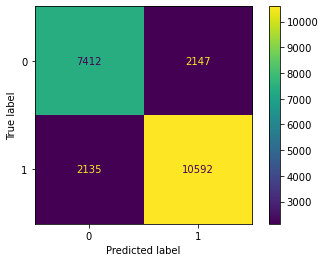

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = ml_pipe.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

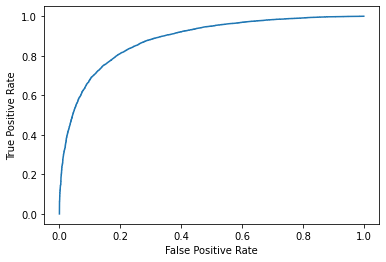

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = ml_pipe.decision_function(X_valid)

fpr, tpr, _ = roc_curve(y_valid, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

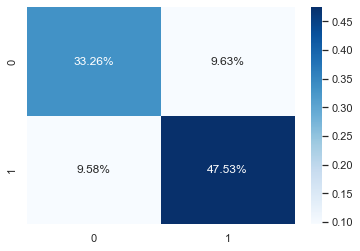

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_style('whitegrid')
sns.set_palette('dark')

sns.heatmap(confusion/np.sum(confusion), annot=True, fmt='.2%', cmap='Blues')
plt.savefig(Path.cwd()/'Report'/'DSL-report'/'images'/'conf_matrix_SVC.png', dpi = 200)

Manually removing users: 0.8019786529108555  
Without manually removing users: 0.8007152526552623

removing duplicate rows : 0.8047867104222173
removing duplicate rows + removal of users with highest similarity : 0.8047867104222173

None : 0.7973008380157585  
text_noAmpEnt : 0.806213112745712  
text_noQuotEnt : 0.806582931090972  
text_noAt : 0.7998564194923328 -- saltato  
text_noAmp : 0.7994236544375262 -- saltato  
text_noHttp : 0.7997304233939981 -- saltato  
text_noDuplLetters : 0.8017853157058441 -- saltato  
text_noPunctuation : 0.8020861827824957 --saltato  
text_stem :   
    Porter: 0.8014799266049696  
    Lancaster : 0.7974966469180449  
text_lemm : 0.797157501260997  
text_neg : 0.7973008380157585  

[  
    text_noAmpEnt  
    text_noQuotEnt  
] : 0.806582931090972  
  
[  
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noPunctuation  
    text_lemm  
    text_neg  
] : 0.7982539044206275  
  
[  
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noPunctuation  
    text_stem(Porter)  
    text_neg  
] : 0.8000375978408897  
  
[  
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noPunctuation  
    text_stem(Lancaster)  
    text_neg  
] : 0.7961716118953209  
  
[  
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noPunctuation  
    text_stem(Snowball)  
    text_neg  
] : 0.8006420407066549  

[  
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noPunctuation    
    text_neg  
] : 0.8006420407066549  

[
    text_noAmpEnt  
    text_noQuotEnt  
    text_noAt  
    text_noHttp  
    text_noDuplLetters  
    text_noPunctuation  
    text_stem  
    text_neg  
] : 0.8016248133460189

Best configuration

In [205]:
model = LinearSVC(
    C = 1, 
    class_weight = 'balanced', 
    dual = False, 
    fit_intercept = False, 
    max_iter = 50, 
    penalty = 'l2', 
    random_state = 42, 
    tol = 0.001
)

vectorizer = TfidfVectorizer(
    binary = True, 
    max_df = 1.0, 
    max_features = None, 
    min_df = 1, 
    ngram_range = (1,3), 
    norm = 'l2', 
    smooth_idf = False, 
    stop_words = None, 
    sublinear_tf = False, 
    use_idf = True
)

old best

In [ ]:
model = LinearSVC(
    C = 1, 
    class_weight = 'balanced', 
    dual = False, 
    fit_intercept = False, 
    max_iter = 100, 
    penalty = 'l2', 
    random_state = 42, 
    tol = 0.001
)

vectorizer = TfidfVectorizer(
    binary = True, 
    max_df = 1.0, 
    max_features = None, 
    min_df = 1, 
    ngram_range = (1,3), 
    norm = 'l2', 
    smooth_idf = False, 
    stop_words = None, 
    sublinear_tf = False, 
    use_idf = True
)

+ NO stemming: 0.7953890537516292
+ Snowball: 0.7994796670641988
+ Lancaster: 0.7934227929849921
+ Porter: 0.7982780155296589
+ Wordnet: 0.7942085265529459

Results generation

In [68]:
ml_pipe.fit(X_train_valid, y_train_valid)
y_pred = ml_pipe.predict(X_test)
pd.DataFrame(y_pred.astype(int),columns=['Predicted']).to_csv("output_SVC_final.csv",index_label="Id", header=["Predicted"])

In [69]:
y_pred.shape

(74999,)